In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *
import joblib

In [2]:
train = pd.read_csv('train_fs.csv', index_col=0)
test = pd.read_csv('test_fs.csv', index_col=0)
cli=['age','apoe4']
train=train.drop(cli,axis=1)
test=test.drop(cli,axis=1)
x_train_fs= train.drop(['Type'], axis = 1)
y_train = train['Type'].values
x_test_fs = test.drop(['Type'], axis = 1)
y_test=  test['Type'].values
print('x_train_fs: ' , x_train_fs.shape)
print('x_test_fs: ' , x_test_fs.shape)
x_train_fs.head(3)

x_train_fs:  (365, 17)
x_test_fs:  (92, 17)


,hsa-miR-4687-3p|hsa-miR-92a-2-5p,hsa-miR-6813-5p|hsa-miR-5195-3p,hsa-miR-1908-3p|hsa-miR-5698,hsa-miR-5001-3p|hsa-miR-4756-3p,hsa-miR-5001-3p|hsa-miR-1322,hsa-miR-5001-3p|hsa-miR-4477a,hsa-miR-5001-3p|hsa-miR-873-5p,hsa-miR-5001-3p|hsa-miR-1253,hsa-miR-5001-3p|hsa-miR-3677-3p,hsa-miR-5001-3p|hsa-miR-335-3p,hsa-miR-5001-3p|hsa-miR-140-3p,hsa-miR-5001-3p|hsa-miR-3976,hsa-miR-6514-5p|hsa-miR-5001-3p,hsa-miR-5001-3p|hsa-miR-561-3p,hsa-miR-5001-3p|hsa-miR-4793-5p,hsa-miR-5001-3p|hsa-miR-875-3p,hsa-miR-5001-3p|hsa-miR-3148
geo_accession,,,,,,,,,,,,,,,,,
GSM3405231,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GSM3404901,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0
GSM3405167,-1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
random_state=16
cv=StratifiedKFold(n_splits=3,shuffle=True,random_state=random_state)

In [4]:
#SVM
svm_clf=SVC(probability=True)
kernel=['rbf','linear']
C=[0.0002,0.002,0.2,2,20,200]
gamma=[0.0002,0.002,0.2,2,20,200]
param_grid=[{'kernel':kernel,'C':C,'gamma':gamma}]
svm_grid_search=GridSearchCV(svm_clf,param_grid=param_grid,cv=cv)
svm_grid_search.fit(x_train_fs,y_train)
joblib.dump(svm_grid_search,'DLB1.pkl')
print('SVM best_params is:',svm_grid_search.best_params_)

#LR
lr_clf=LogisticRegression(max_iter=10000)
penalty=['l2']
C=[0.0001,0.001,0.01,0.1]
param_grid=[{'C':C,'penalty':penalty}]
lr_grid_search=GridSearchCV(lr_clf,param_grid=param_grid,cv=cv)
lr_grid_search.fit(x_train_fs,y_train)
joblib.dump(lr_grid_search,'DLB2.pkl')
print('LR best_params is:',lr_grid_search.best_params_)

SVM best_params is: {'C': 2, 'gamma': 0.0002, 'kernel': 'linear'}
LR best_params is: {'C': 0.1, 'penalty': 'l2'}


In [5]:
def train_performance(model,x_train,y_train,color,name):
    se=[]
    sp=[]
    f1=[]
    accuracy=[]
    tprs=[]
    aucs=[]   
    mean_fpr=np.linspace(0,1,100)
    i=0
    for train_index,test_index in cv.split(x_train,y_train):

        X_train,X_test = x_train.iloc[train_index,:],x_train.iloc[test_index,:]
        Y_train,Y_test = y_train[train_index],y_train[test_index]

        Y_pred=model.predict(X_test)
        Y_probs=model.predict_proba(X_test)
        
        my_cla_score= classification_report(Y_test,Y_pred,output_dict=True) 
        SE = my_cla_score['1']['recall']
        SP = my_cla_score['0']['recall']  
        ACC=accuracy_score(Y_test, Y_pred)
        F1=f1_score(Y_test, Y_pred, average='weighted')
        AUC=roc_auc_score(Y_test,Y_probs[:,-1])
        se.append(SE)
        sp.append(SP)
        f1.append(F1)
        accuracy.append(ACC)
        aucs.append(AUC)
        print('%s model ROC fold %d :\t'%(name,i+1),'SE:{:.4f}\t'.format(SE), 'SP:{:.4f}\t'.format(SP),
              'f1-score:{:.4f}\t'.format(F1), 'Accuracy:{:.4f}\t'.format(ACC))
   

        #interp
        fpr,tpr,threshods=roc_curve(Y_test,Y_probs[:,-1])
        tprs.append(np.interp(mean_fpr,fpr,tpr))
        tprs[-1][0]=0.0
        plt.plot(fpr,tpr,lw=1,alpha=0.4,label='ROC fold %d(AUC=%0.4f)'% (i+1,AUC))
        i +=1


    plt.plot([0,1],[0,1],linestyle='--',lw=2,color='black',alpha=1)
    mean_tpr=np.mean(tprs,axis=0)
    mean_tpr[-1]=1.0
    mean_auc=auc(mean_fpr,mean_tpr)
    mean_SE=np.mean(se)
    mean_SP=np.mean(sp)
    mean_f1=np.mean(f1)
    mean_accuracy=np.mean(accuracy)
    print('%s model :\t'%(name),'SE:{:.4f}\t'.format(mean_SE), 'SP:{:.4f}\t'.format(mean_SP),
          'f1-score:{:.4f}\t'.format(mean_f1),'Accuracy:{:.4f}\t'.format(mean_accuracy))

    std_se=np.std(se,axis=0)
    std_sp=np.std(sp,axis=0)
    std_f1=np.std(f1,axis=0)
    std_auc=np.std(aucs,axis=0)
    std_accuracy=np.std(accuracy,axis=0)
    print('%s model :\t'%(name),'std_se:{:.4f}\t'.format(std_se), 'std_sp:{:.4f}\t'.format(std_sp),
          'std_f1:{:.4f}\t'.format(std_f1),'std_accuracy:{:.4f} \t'.format(std_accuracy))
    
    plt.plot(mean_fpr,mean_tpr,color=color,label='%s(AUC=%0.4f $\pm$ %0.4f)'% (name,mean_auc,std_auc),lw=2,alpha=.9)
    std_tpr=np.std(tprs,axis=0)
    tprs_upper=np.minimum(mean_tpr+std_tpr,1)
    tprs_lower=np.maximum(mean_tpr-std_tpr,0)
    plt.fill_between(mean_fpr,tprs_lower,tprs_upper,color='gray',alpha=.3,label=r'$\pm$ 1 std. dev.')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    return


def test_performance(model,x_test,y_test,color,name):
    print('test_results of %s :'% name)
    y_pred=model.predict(x_test)
    y_probs=model.predict_proba(x_test)
    my_cla_score= classification_report(y_test,y_pred,output_dict=True) 
    SE = my_cla_score['1']['recall']
    SP = my_cla_score['0']['recall']  
    accuracy=accuracy_score(y_test, y_pred)
    f1=f1_score(y_test, y_pred, average='weighted')
    roc_auc=roc_auc_score(y_test,y_probs[:,-1])
    print('%s model :\t'%(name), 'SE:{:.4f}\t'.format(SE), 'SP:{:.4f}\t'.format(SP),
      'f1-score:{:.4f}\t'.format(f1),'ROC AUC:{:.4f}\t'.format(roc_auc), 'Accuracy:{:.4f}\t'.format(accuracy))
    fpr,tpr,threshods=roc_curve(y_test,y_probs[:,-1])
    plt.plot([0,1],[0,1],linestyle='--',lw=2,color='black')
    plt.plot(fpr,tpr,color=color,label=r'%s(AUC=%0.4f)'%(name,roc_auc))
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    return

DLB1 model ROC fold 1 :	 SE:0.4889	 SP:0.9610	 f1-score:0.7687	 Accuracy:0.7869	
DLB1 model ROC fold 2 :	 SE:0.6222	 SP:0.8442	 f1-score:0.7590	 Accuracy:0.7623	
DLB1 model ROC fold 3 :	 SE:0.8000	 SP:0.9737	 f1-score:0.9073	 Accuracy:0.9091	
DLB1 model :	 SE:0.6370	 SP:0.9263	 f1-score:0.8117	 Accuracy:0.8194	
DLB1 model :	 std_se:0.1274	 std_sp:0.0583	 std_f1:0.0677	 std_accuracy:0.0642 	


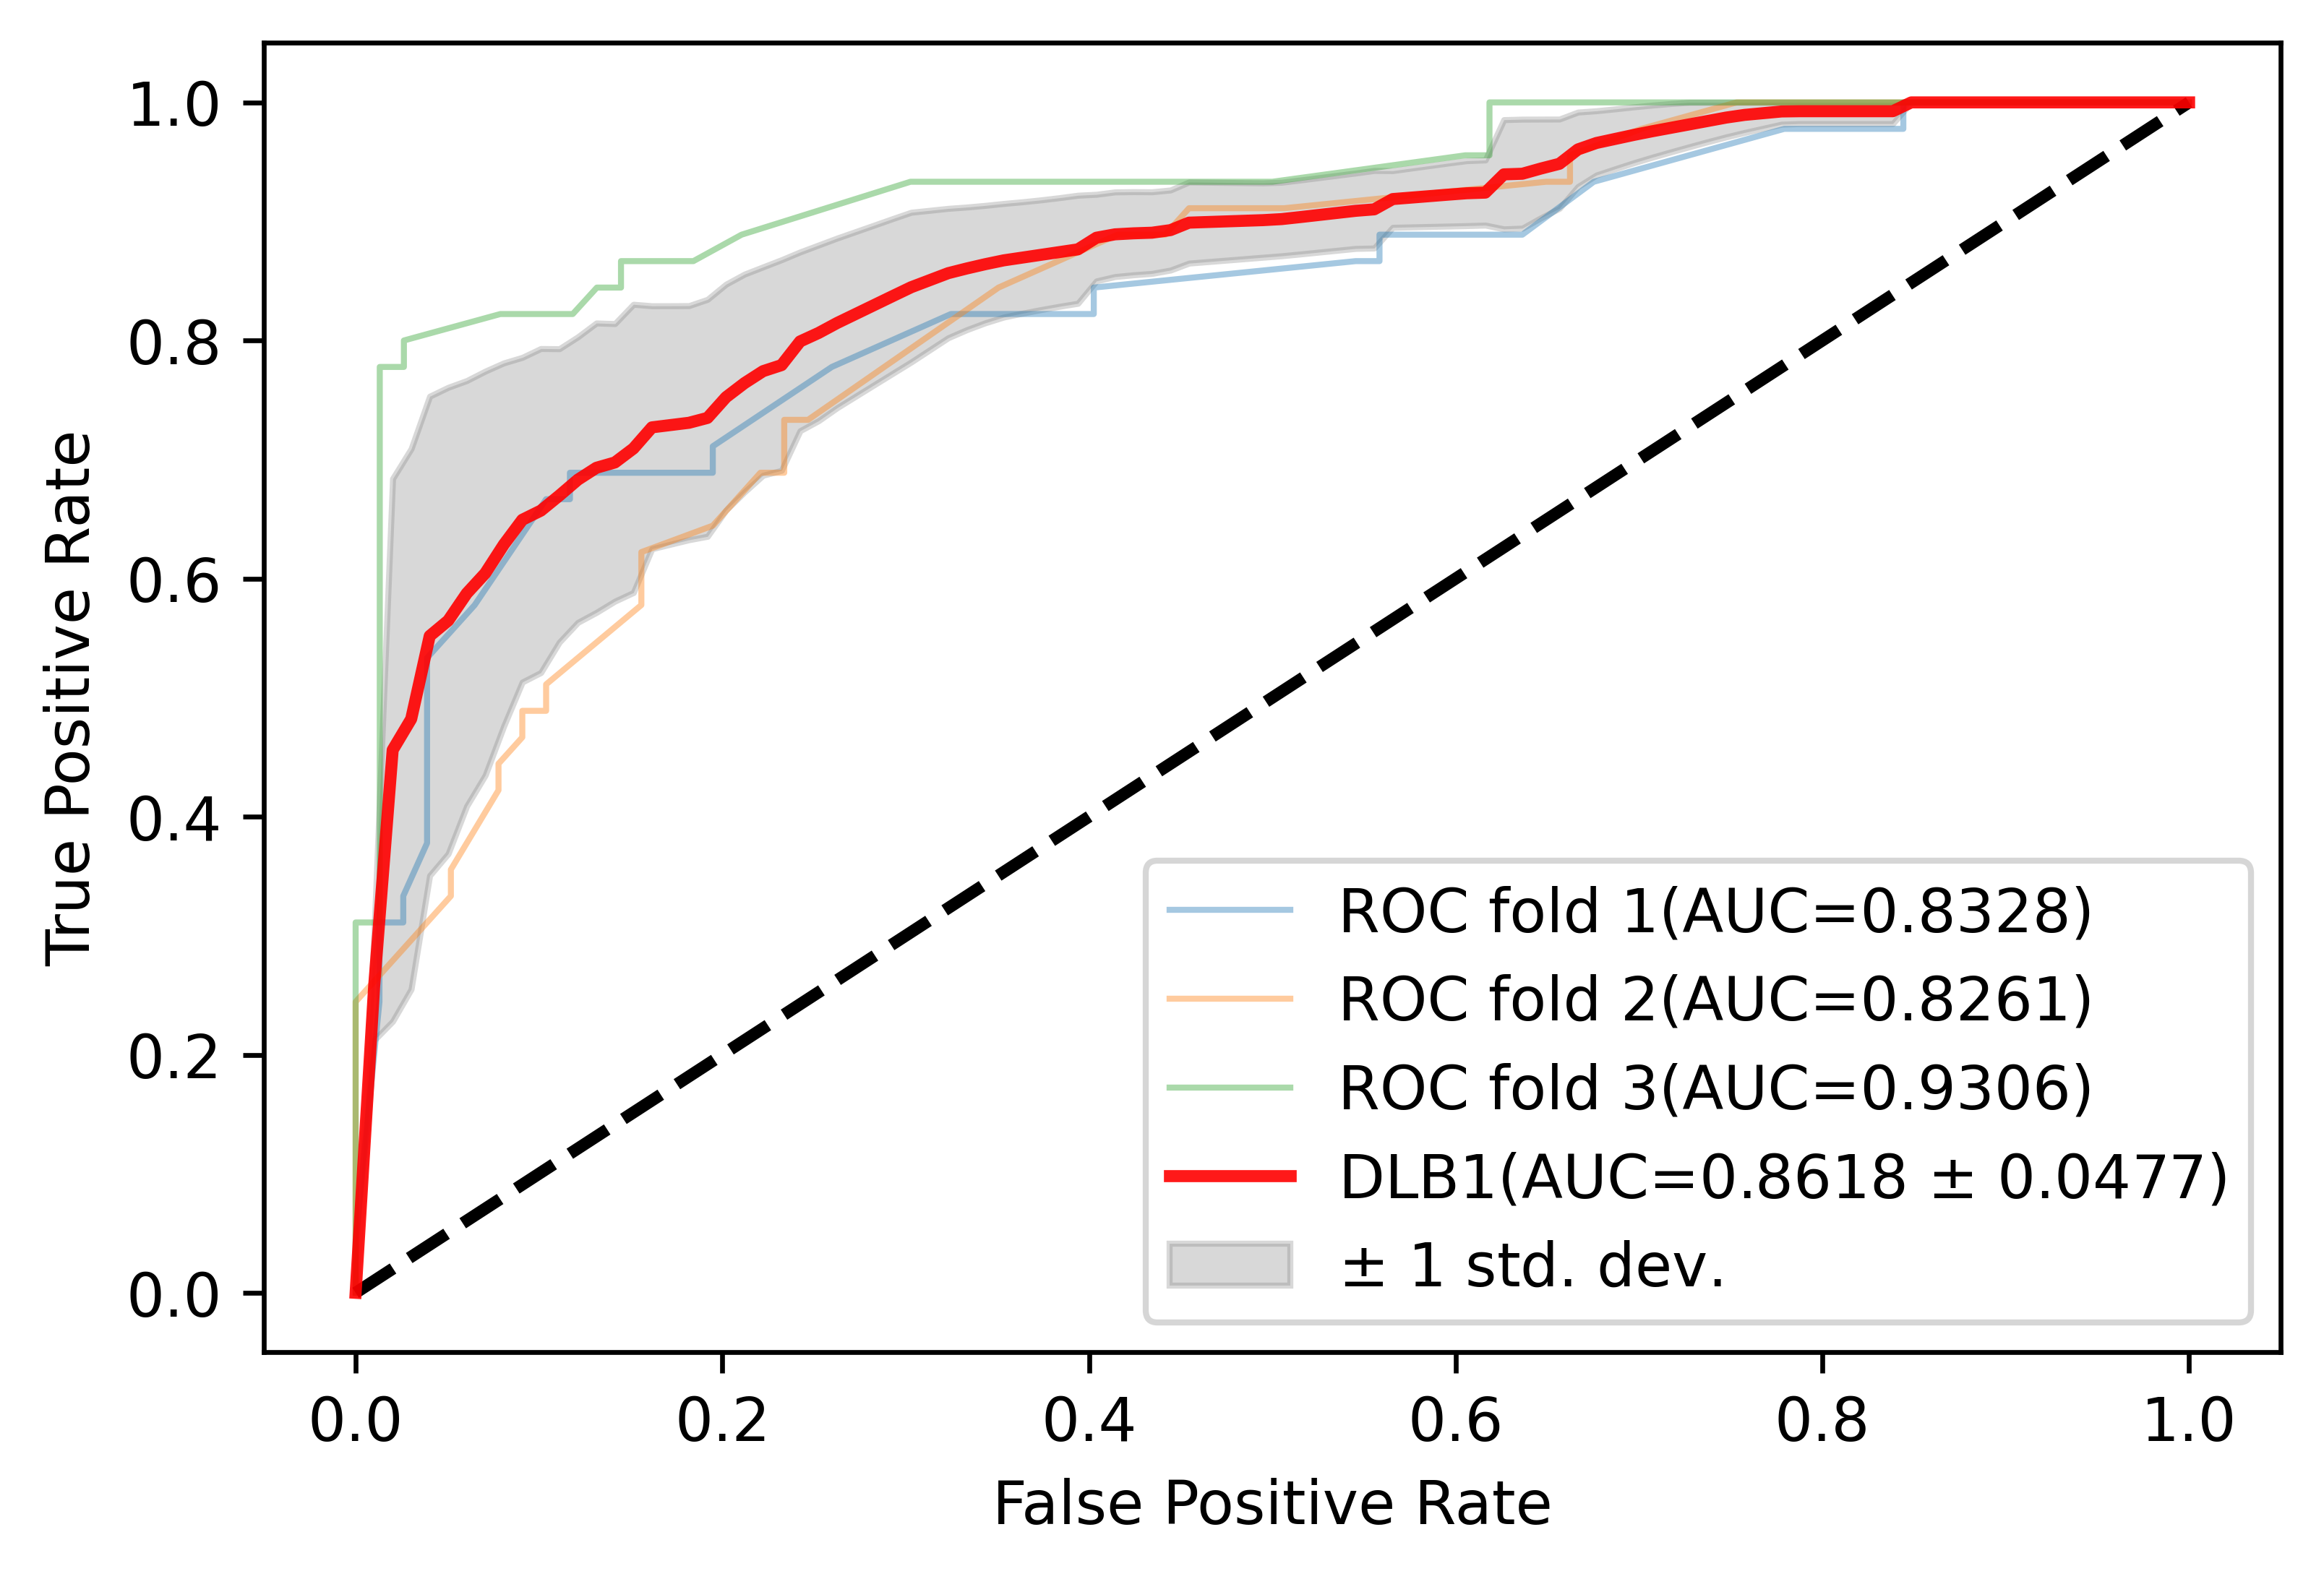

In [6]:
fig = plt.figure(dpi=600)
plt.grid(b=False)
train_performance(model=svm_grid_search,x_train=x_train_fs,y_train=y_train,name='DLB1',color='red')

DLB2 model ROC fold 1 :	 SE:0.4222	 SP:0.9351	 f1-score:0.7225	 Accuracy:0.7459	
DLB2 model ROC fold 2 :	 SE:0.5778	 SP:0.8442	 f1-score:0.7407	 Accuracy:0.7459	
DLB2 model ROC fold 3 :	 SE:0.7778	 SP:0.9474	 f1-score:0.8824	 Accuracy:0.8843	
DLB2 model :	 SE:0.5926	 SP:0.9089	 f1-score:0.7819	 Accuracy:0.7920	
DLB2 model :	 std_se:0.1455	 std_sp:0.0460	 std_f1:0.0715	 std_accuracy:0.0652 	


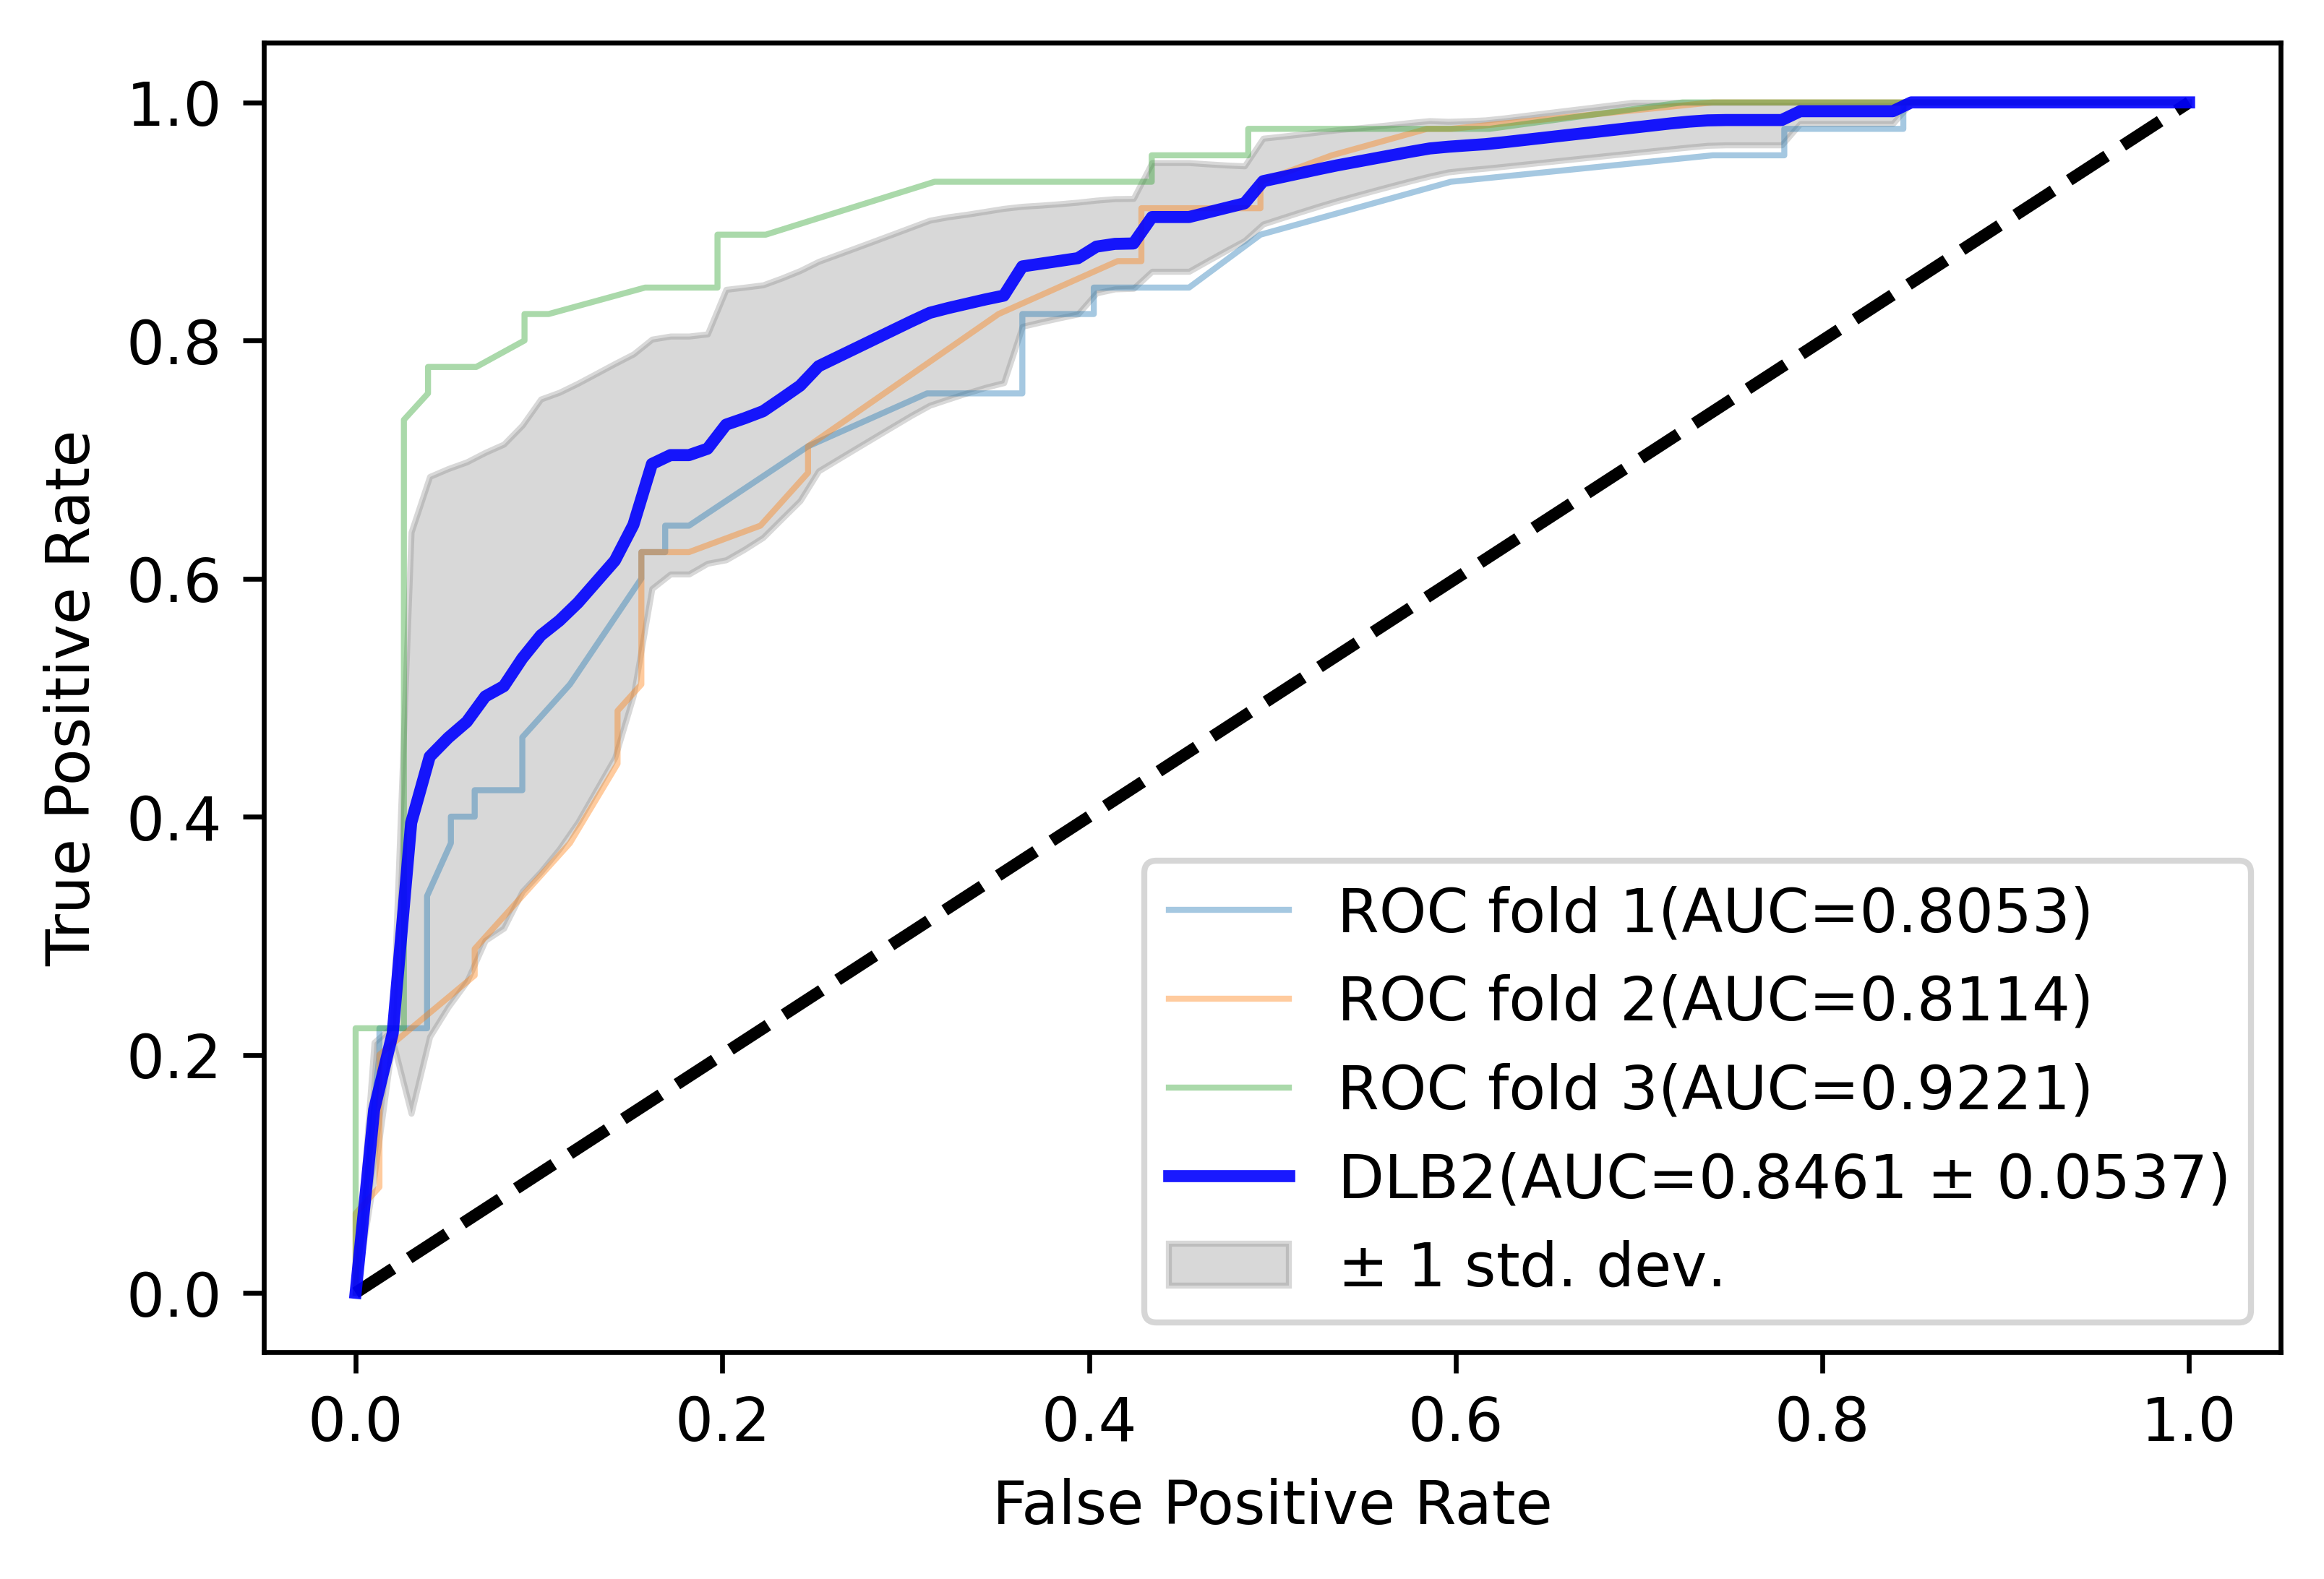

In [7]:
fig = plt.figure(dpi=600)
plt.grid(b=False)
train_performance(model=lr_grid_search,x_train=x_train_fs,y_train=y_train,name='DLB2',color='blue')

test_results of DLB1 :
DLB1 model :	 SE:0.4412	 SP:0.9138	 f1-score:0.7194	 ROC AUC:0.7279	 Accuracy:0.7391	
test_results of DLB2 :
DLB2 model :	 SE:0.4706	 SP:0.9138	 f1-score:0.7331	 ROC AUC:0.7234	 Accuracy:0.7500	


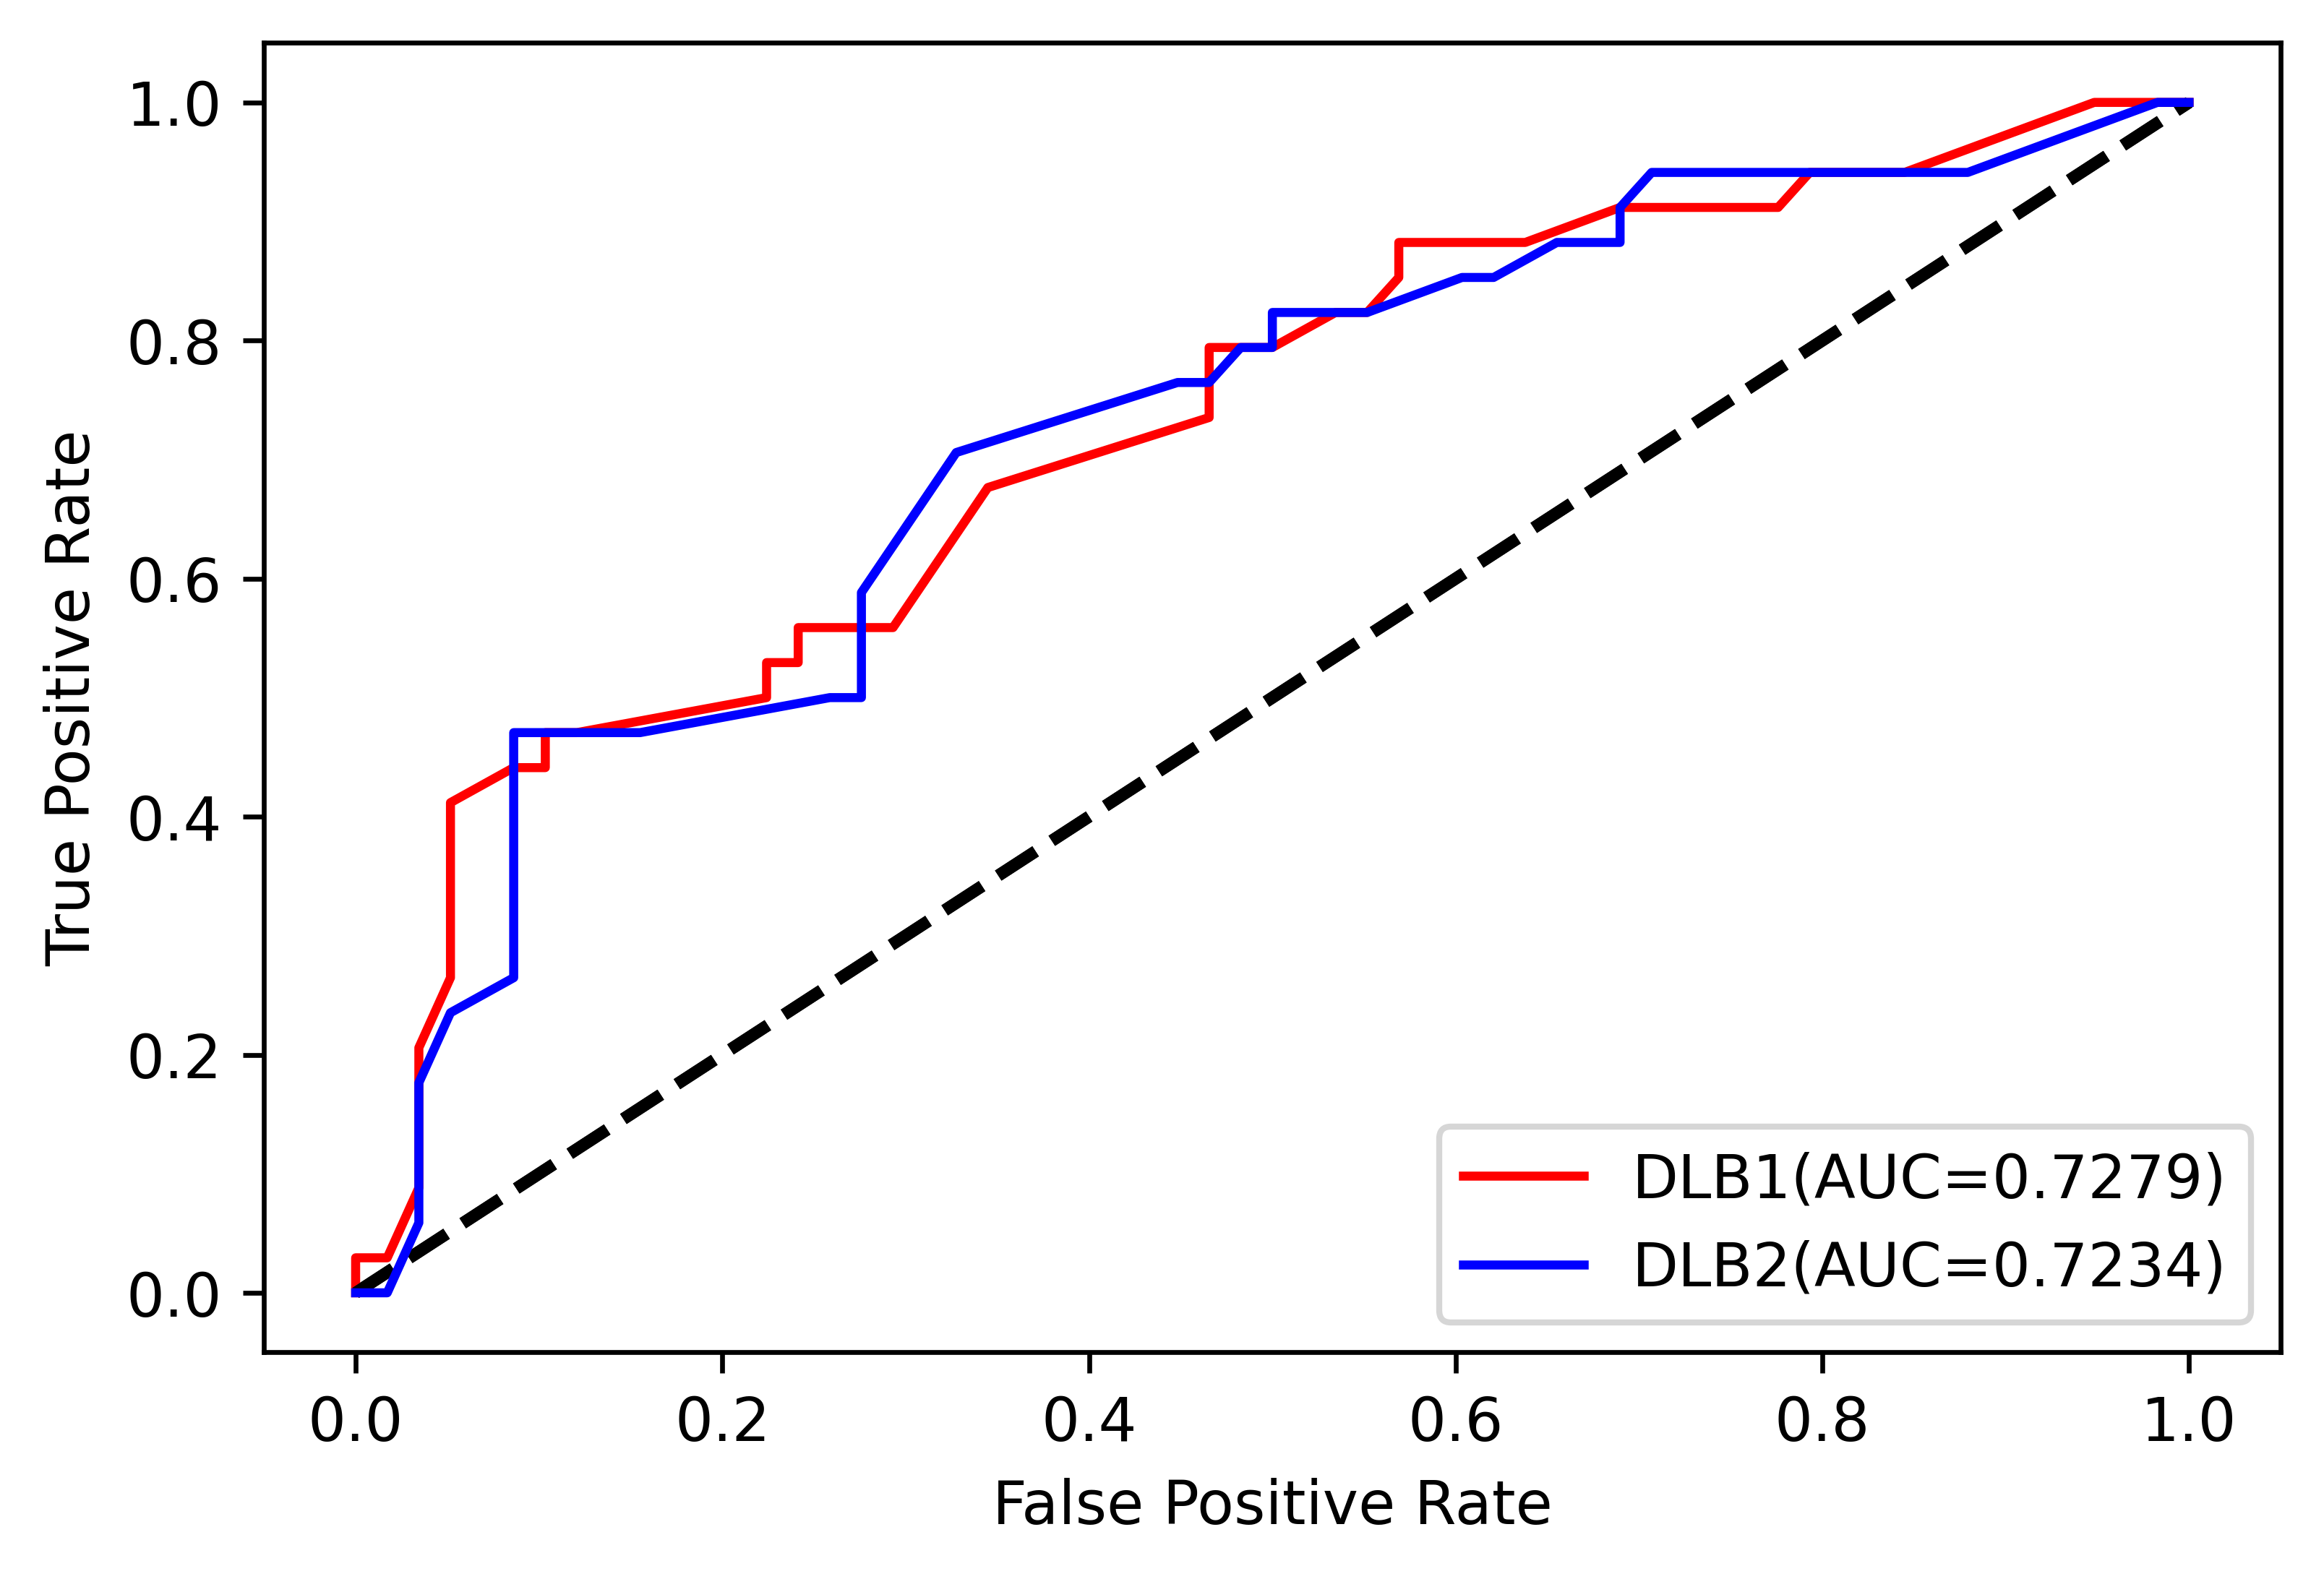

In [8]:
fig = plt.figure(dpi=600)
plt.grid(b=False)
test_performance(model=svm_grid_search,x_test=x_test_fs,y_test=y_test,color='red',name='DLB1')
test_performance(model=lr_grid_search,x_test=x_test_fs,y_test=y_test,color='blue',name='DLB2')